In [1]:
import bnlearn as bn
import pandas as pd
import torch
import torch.nn as nn
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import copy
import json

import random
import requests

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import io

import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from pgmpy.estimators import PC
from pgmpy.base import DAG


from causallearn.search.FCMBased import lingam
from causallearn.search.ScoreBased.GES import ges
from pgmpy.metrics import correlation_score
import sys

from causallearn.utils.PDAG2DAG import pdag2dag
from causallearn.utils.GraphUtils import GraphUtils


## Helper functions

In [2]:
def generate_plots(graph, labels):
    plt.figure(figsize=(10,5))
    pyd = GraphUtils.to_pydot(graph, labels=labels)
    tmp_png = pyd.create_png(f="png")
    fp = io.BytesIO(tmp_png)
    img = mpimg.imread(fp, format='png')
    plt.axis('off')
    plt.imshow(img)
    plt.show()

In [72]:
def undirected_SHD(g1, g2):
    g1 = np.tril(((g1 + g1.T) > 0).astype(int))
    g2 = np.tril(((g2 + g2.T) > 0).astype(int))
    return np.sum(np.abs(g1-g2))

In [93]:
def comb_SHD(g1, g2):
    return np.sum(np.abs(g1 - g2)), undirected_SHD(g1,g2)

In [74]:
def get_graph_pass_SHD(data,model, g):
    return SHD(model['adjmat'].to_numpy().astype(int),  nx.adjacency_matrix(g, nodelist=data.columns))

In [75]:
def generate_splits(data, num_samples, seed):
    return np.split(data.sample(frac=1, random_state = seed), [int(num_samples*0.6), int(num_samples*0.8)])

In [96]:
def run_ges(data, model, seed, plot=False):
    try:
        ret = ges(data)
        ret_graph = ret['G'].graph
        frmt_adj = (ret_graph == -1).astype(int)
        shd = comb_SHD(frmt_adj, model['adjmat'].to_numpy().astype(int))
        return shd
    except:
        return -1

In [97]:
def run_LINGAM(data,df_model,full_df, seed, plot=False):
    model = lingam.DirectLiNGAM(random_state=seed)
    model.fit(data)
    g = nx.from_pandas_adjacency(pd.DataFrame((model.adjacency_matrix_ > 0).astype(int), columns=full_df.columns, index=full_df.columns), create_using=nx.DiGraph())
    shd = comb_SHD(nx.adjacency_matrix(g, full_df.columns).toarray(), df_model['adjmat'].to_numpy().astype(int))
    return shd

In [98]:
def run_pc(data,model, df_data, seed, plot=False):
    pdag = PC(data).estimate(return_type='dag')
    g = nx.DiGraph()
    g.add_nodes_from(data.columns)
    for i in pdag.edges():
        g.add_edge(i[0], i[1])
    
    if plot:
        pos = nx.nx_pydot.pydot_layout(g)
        nx.draw_networkx(g,pos)
    shd1,shd2 = comb_SHD(nx.adjacency_matrix(g, df_data.columns).toarray(), model['adjmat'].to_numpy().astype(int))
    return shd1, shd2

In [107]:
def run_experiments(datasets,models, data_splits, data_names, algo_names, metric_names, seed):
    scores = {}
    data_split_names = [
        "train",
        "val",
        "test"
    ]
    for i in range(len(datasets)):
        d = datasets[i]
        if scores.get(data_names[i]) == None:
            scores[data_names[i]] = {}
        if scores[data_names[i]].get(algo_names[i]) == None:
            scores[data_names[i]][algo_names[i]] = {}
        for l in range(len(data_split_names)):
            if algo_names[i] == "lingam":
                scores[data_names[i]][algo_names[i]][data_split_names[l]] = {}
                shds = run_LINGAM(data_splits[i][l], models[i], datasets[i], seed)
                scores[data_names[i]][algo_names[i]][data_split_names[l]]["shd_dir"] = shds[0]
                scores[data_names[i]][algo_names[i]][data_split_names[l]]["shd_undir"] = shds[1]
            elif algo_names[i] == "pc":
                scores[data_names[i]][algo_names[i]][data_split_names[l]] = {}
                shds = run_pc(data_splits[i][l], models[i], datasets[i], seed)
                scores[data_names[i]][algo_names[i]][data_split_names[l]]["shd_dir"] = shds[0]
                scores[data_names[i]][algo_names[i]][data_split_names[l]]["shd_undir"] = shds[1]
            elif algo_names[i] == 'ges':
                scores[data_names[i]][algo_names[i]][data_split_names[l]] = {}
                shds = run_ges(data_splits[i][l], models[i], seed)
                print(shds)
                scores[data_names[i]][algo_names[i]][data_split_names[l]]["shd_dir"] = shds[0]
                scores[data_names[i]][algo_names[i]][data_split_names[l]]["shd_undir"] = shds[1]
    return scores

## Generate networks

In [100]:
seeds = np.random.randint(1, 2**32 - 5, size=(5,))

In [109]:
seeds = [ 914013600, 3123865728, 2845696281, 2887946789, 3535960643]

In [112]:
seeds

[914013600, 3123865728, 2845696281, 2887946789, 3535960643]

In [113]:
comb_metrics = []
for i in seeds:
    np.random.seed(i)
    num_samples = 10000
    file_name = "asia"
    model_asia = bn.import_DAG("BIFs/" + file_name + ".bif")
    df_asia = bn.sampling(model_asia, n=num_samples)
    # df_asia = df_asia.drop(file_name, axis=1)
    nodes_orig = list(model_asia['adjmat'].columns)
    asia_dag = DAG(model_asia['adjmat'])
    
    np.random.seed(i)
    file_name = "cancer"
    model_cancer = bn.import_DAG("BIFs/" + file_name + ".bif")
    df_cancer = bn.sampling(model_cancer, n=num_samples)
    nodes_orig = df_cancer.columns

    np.random.seed(i)
    model_child = bn.import_DAG("BIFs/child.bif")
    df_child = bn.sampling(model_child, n=num_samples)
    nodes_orig = df_child.columns

    np.random.seed(i)
    model_insurance = bn.import_DAG("BIFs/insurance.bif")
    df_insurance = bn.sampling(model_insurance, n=num_samples)
    nodes_orig = df_insurance.columns

    inp_dfs = [df_asia, df_asia,df_asia, df_cancer,df_cancer,df_cancer, df_child, df_child,df_child, df_insurance, df_insurance, df_insurance]

    ret_metrics = run_experiments(
    inp_dfs,
    [model_asia, model_asia, model_asia, model_cancer, model_cancer,model_cancer, model_child, model_child,model_child, model_insurance, model_insurance, model_insurance],
    [
     generate_splits(d, num_samples, i) for d in inp_dfs
    ],
    ["asia","asia","asia","cancer","cancer", "cancer", "child", "child", "child", "insurance", "insurance", "insurance"],
    ["pc","lingam","ges","pc","lingam","ges","pc","lingam","ges", "pc","lingam","ges"],
    ["SHD","corr","SHD","SHD","corr","SHD","SHD", "corr","SHD","SHD","corr","SHD"],
        i
    )
    comb_metrics.append(ret_metrics)

[bnlearn] >Import <BIFs/asia.bif>
[bnlearn] >Loading bif file <BIFs/asia.bif>
[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >Import <BIFs/cancer.bif>
[bnlearn] >Loading bif file <BIFs/cancer.bif>
[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >Import <BIFs/child.bif>
[bnlearn] >Loading bif file <BIFs/child.bif>


[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 3.3306690738754696e-16. Adjusting values.


[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >CPD [Age] does not add up to 1 but is: [[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[bnlearn] >CPD [ChestXray] does not add up to 1 but is: [[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
[bnlearn] >CPD [HypoxiaInO2] does not add up to 1 but is: [[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
[bnlearn] >CPD [LowerBodyO2] does not add up to 1 but is: [[1. 1. 1.]
 [1. 1. 1.]]
[bnlearn] >CPD [RUQO2] does not add up to 1 but is: [1. 1. 1.]
[bnlearn] >CPD [XrayReport] does not add up to 1 but is: [1. 1. 1. 1. 1.]
[bnlearn] >Import <BIFs/insurance.bif>
[bnlearn] >Loading bif file <BIFs/insurance.bif>


[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
[setgraphviz] >WARNING> Probability value

[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >CPD [Accident] does not add up to 1 but is: [[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]
[bnlearn] >CPD [CarValue] does not add up to 1 but is: [[[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]]
[bnlearn] >CPD [DrivHist] does not add up to 1 but is: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[bnlearn] >CPD [DrivingSkill] does not add up to 1 but is: [[1. 1.]
 [1. 1.]
 [1. 1.]]
[bnlearn] >CPD [HomeBase] does not add up to 1 but is: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[bnlearn] >CPD [MedCost] does not add up to 1 but is: [[[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]]
[bnlearn]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

(3, 1)
(3, 1)
(3, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

(3, 1)
(4, 2)
(4, 2)


  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


(32, 20)
(34, 11)
(30, 11)


  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


(46, 35)
(48, 32)
(36, 27)
[bnlearn] >Import <BIFs/asia.bif>
[bnlearn] >Loading bif file <BIFs/asia.bif>
[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >Import <BIFs/cancer.bif>
[bnlearn] >Loading bif file <BIFs/cancer.bif>
[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >Import <BIFs/child.bif>
[bnlearn] >Loading bif file <BIFs/child.bif>


[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 3.3306690738754696e-16. Adjusting values.


[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >CPD [Age] does not add up to 1 but is: [[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[bnlearn] >CPD [ChestXray] does not add up to 1 but is: [[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
[bnlearn] >CPD [HypoxiaInO2] does not add up to 1 but is: [[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
[bnlearn] >CPD [LowerBodyO2] does not add up to 1 but is: [[1. 1. 1.]
 [1. 1. 1.]]
[bnlearn] >CPD [RUQO2] does not add up to 1 but is: [1. 1. 1.]
[bnlearn] >CPD [XrayReport] does not add up to 1 but is: [1. 1. 1. 1. 1.]
[bnlearn] >Import <BIFs/insurance.bif>
[bnlearn] >Loading bif file <BIFs/insurance.bif>


[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
[setgraphviz] >WARNING> Probability value

[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >CPD [Accident] does not add up to 1 but is: [[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]
[bnlearn] >CPD [CarValue] does not add up to 1 but is: [[[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]]
[bnlearn] >CPD [DrivHist] does not add up to 1 but is: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[bnlearn] >CPD [DrivingSkill] does not add up to 1 but is: [[1. 1.]
 [1. 1.]
 [1. 1.]]
[bnlearn] >CPD [HomeBase] does not add up to 1 but is: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[bnlearn] >CPD [MedCost] does not add up to 1 but is: [[[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]]
[bnlearn]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

(3, 1)
(6, 1)
(8, 8)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

(4, 1)
(3, 1)
(3, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


(29, 18)
(33, 12)
(24, 13)


  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


(43, 32)
(38, 29)
(35, 24)
[bnlearn] >Import <BIFs/asia.bif>
[bnlearn] >Loading bif file <BIFs/asia.bif>
[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >Import <BIFs/cancer.bif>
[bnlearn] >Loading bif file <BIFs/cancer.bif>
[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >Import <BIFs/child.bif>
[bnlearn] >Loading bif file <BIFs/child.bif>


[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 3.3306690738754696e-16. Adjusting values.


[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >CPD [Age] does not add up to 1 but is: [[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[bnlearn] >CPD [ChestXray] does not add up to 1 but is: [[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
[bnlearn] >CPD [HypoxiaInO2] does not add up to 1 but is: [[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
[bnlearn] >CPD [LowerBodyO2] does not add up to 1 but is: [[1. 1. 1.]
 [1. 1. 1.]]
[bnlearn] >CPD [RUQO2] does not add up to 1 but is: [1. 1. 1.]
[bnlearn] >CPD [XrayReport] does not add up to 1 but is: [1. 1. 1. 1. 1.]
[bnlearn] >Import <BIFs/insurance.bif>
[bnlearn] >Loading bif file <BIFs/insurance.bif>


[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
[setgraphviz] >WARNING> Probability value

[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >CPD [Accident] does not add up to 1 but is: [[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]
[bnlearn] >CPD [CarValue] does not add up to 1 but is: [[[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]]
[bnlearn] >CPD [DrivHist] does not add up to 1 but is: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[bnlearn] >CPD [DrivingSkill] does not add up to 1 but is: [[1. 1.]
 [1. 1.]
 [1. 1.]]
[bnlearn] >CPD [HomeBase] does not add up to 1 but is: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[bnlearn] >CPD [MedCost] does not add up to 1 but is: [[[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]]
[bnlearn]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

(3, 1)
(8, 3)
(3, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

(4, 1)
(4, 2)
(3, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


(38, 20)
(31, 11)
(28, 15)


  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


(70, 50)
(42, 31)
(61, 38)
[bnlearn] >Import <BIFs/asia.bif>
[bnlearn] >Loading bif file <BIFs/asia.bif>
[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >Import <BIFs/cancer.bif>
[bnlearn] >Loading bif file <BIFs/cancer.bif>
[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >Import <BIFs/child.bif>
[bnlearn] >Loading bif file <BIFs/child.bif>


[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 3.3306690738754696e-16. Adjusting values.


[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >CPD [Age] does not add up to 1 but is: [[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[bnlearn] >CPD [ChestXray] does not add up to 1 but is: [[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
[bnlearn] >CPD [HypoxiaInO2] does not add up to 1 but is: [[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
[bnlearn] >CPD [LowerBodyO2] does not add up to 1 but is: [[1. 1. 1.]
 [1. 1. 1.]]
[bnlearn] >CPD [RUQO2] does not add up to 1 but is: [1. 1. 1.]
[bnlearn] >CPD [XrayReport] does not add up to 1 but is: [1. 1. 1. 1. 1.]
[bnlearn] >Import <BIFs/insurance.bif>
[bnlearn] >Loading bif file <BIFs/insurance.bif>


[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
[setgraphviz] >WARNING> Probability value

[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >CPD [Accident] does not add up to 1 but is: [[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]
[bnlearn] >CPD [CarValue] does not add up to 1 but is: [[[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]]
[bnlearn] >CPD [DrivHist] does not add up to 1 but is: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[bnlearn] >CPD [DrivingSkill] does not add up to 1 but is: [[1. 1.]
 [1. 1.]
 [1. 1.]]
[bnlearn] >CPD [HomeBase] does not add up to 1 but is: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[bnlearn] >CPD [MedCost] does not add up to 1 but is: [[[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]]
[bnlearn]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

(4, 1)
(7, 3)
(3, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

(2, 0)
(3, 1)
(7, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


(30, 19)
(30, 11)
(38, 12)


  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


(71, 48)
(62, 44)
(40, 27)
[bnlearn] >Import <BIFs/asia.bif>
[bnlearn] >Loading bif file <BIFs/asia.bif>
[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >Import <BIFs/cancer.bif>
[bnlearn] >Loading bif file <BIFs/cancer.bif>
[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >Import <BIFs/child.bif>
[bnlearn] >Loading bif file <BIFs/child.bif>


[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 3.3306690738754696e-16. Adjusting values.


[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >CPD [Age] does not add up to 1 but is: [[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[bnlearn] >CPD [ChestXray] does not add up to 1 but is: [[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
[bnlearn] >CPD [HypoxiaInO2] does not add up to 1 but is: [[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
[bnlearn] >CPD [LowerBodyO2] does not add up to 1 but is: [[1. 1. 1.]
 [1. 1. 1.]]
[bnlearn] >CPD [RUQO2] does not add up to 1 but is: [1. 1. 1.]
[bnlearn] >CPD [XrayReport] does not add up to 1 but is: [1. 1. 1. 1. 1.]
[bnlearn] >Import <BIFs/insurance.bif>
[bnlearn] >Loading bif file <BIFs/insurance.bif>


[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
[setgraphviz] >WARNING> Probability value

[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >CPD [Accident] does not add up to 1 but is: [[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]
[bnlearn] >CPD [CarValue] does not add up to 1 but is: [[[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]]
[bnlearn] >CPD [DrivHist] does not add up to 1 but is: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[bnlearn] >CPD [DrivingSkill] does not add up to 1 but is: [[1. 1.]
 [1. 1.]
 [1. 1.]]
[bnlearn] >CPD [HomeBase] does not add up to 1 but is: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[bnlearn] >CPD [MedCost] does not add up to 1 but is: [[[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]]
[bnlearn]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

(3, 0)
(3, 1)
(5, 4)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

(2, 0)
(3, 1)
(3, 1)


  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


(33, 20)
(33, 11)
(29, 9)


  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


(45, 34)
(57, 42)
(44, 29)


In [114]:
backup_comb_metrics = copy.deepcopy(comb_metrics)

In [115]:
comb_metrics

[{'asia': {'pc': {'train': {'shd_dir': 2, 'shd_undir': 2},
    'val': {'shd_dir': 8, 'shd_undir': 2},
    'test': {'shd_dir': 8, 'shd_undir': 4}},
   'lingam': {'train': {'shd_dir': 10, 'shd_undir': 4},
    'val': {'shd_dir': 10, 'shd_undir': 4},
    'test': {'shd_dir': 14, 'shd_undir': 4}},
   'ges': {'train': {'shd_dir': 3, 'shd_undir': 1},
    'val': {'shd_dir': 3, 'shd_undir': 1},
    'test': {'shd_dir': 3, 'shd_undir': 1}}},
  'cancer': {'pc': {'train': {'shd_dir': 4, 'shd_undir': 0},
    'val': {'shd_dir': 4, 'shd_undir': 2},
    'test': {'shd_dir': 4, 'shd_undir': 2}},
   'lingam': {'train': {'shd_dir': 5, 'shd_undir': 1},
    'val': {'shd_dir': 4, 'shd_undir': 2},
    'test': {'shd_dir': 4, 'shd_undir': 2}},
   'ges': {'train': {'shd_dir': 3, 'shd_undir': 1},
    'val': {'shd_dir': 4, 'shd_undir': 2},
    'test': {'shd_dir': 4, 'shd_undir': 2}}},
  'child': {'pc': {'train': {'shd_dir': 23, 'shd_undir': 9},
    'val': {'shd_dir': 22, 'shd_undir': 8},
    'test': {'shd_dir': 18, 

In [116]:
len(comb_metrics)

5

In [117]:
def get_metrics(bn_dict):
    cols = []
    for algo in bn_dict.keys():
        for splits in bn_dict[algo].keys():
            for metric in bn_dict[algo][splits].keys():
                cols.append([algo, splits, metric, bn_dict[algo][splits][metric]])
    return cols

In [118]:
comb_metrics[0].keys()

dict_keys(['asia', 'cancer', 'child', 'insurance'])

In [119]:
formatted_metrics = []
datasets = comb_metrics[0].keys()
inv_dict = {}
for i in range(len(comb_metrics)):
    run_no = "Run - "+str(i+1)
    seed = "Seed - "+str(seeds[i])
    temp = [run_no, seed]
    for dataset in comb_metrics[i].keys():
        if inv_dict.get(dataset)==None:
            inv_dict[dataset] = []
        temp = [["Run - " + str(i+1)]]
        temp.extend(get_metrics(comb_metrics[i][dataset]))
        inv_dict[dataset].extend(temp)

In [120]:
for i in datasets:
    df = pd.DataFrame(inv_dict[i])
    df.to_csv(i+"_new.csv")
    formatted_metrics.append([i])
    formatted_metrics.extend(inv_dict[i])

In [121]:
for i in datasets:
    formatted_metrics.append([i])
    formatted_metrics.extend(inv_dict[i])

In [122]:
formatted_metrics

[['asia'],
 ['Run - 1'],
 ['pc', 'train', 'shd_dir', 2],
 ['pc', 'train', 'shd_undir', 2],
 ['pc', 'val', 'shd_dir', 8],
 ['pc', 'val', 'shd_undir', 2],
 ['pc', 'test', 'shd_dir', 8],
 ['pc', 'test', 'shd_undir', 4],
 ['lingam', 'train', 'shd_dir', 10],
 ['lingam', 'train', 'shd_undir', 4],
 ['lingam', 'val', 'shd_dir', 10],
 ['lingam', 'val', 'shd_undir', 4],
 ['lingam', 'test', 'shd_dir', 14],
 ['lingam', 'test', 'shd_undir', 4],
 ['ges', 'train', 'shd_dir', 3],
 ['ges', 'train', 'shd_undir', 1],
 ['ges', 'val', 'shd_dir', 3],
 ['ges', 'val', 'shd_undir', 1],
 ['ges', 'test', 'shd_dir', 3],
 ['ges', 'test', 'shd_undir', 1],
 ['Run - 2'],
 ['pc', 'train', 'shd_dir', 8],
 ['pc', 'train', 'shd_undir', 2],
 ['pc', 'val', 'shd_dir', 8],
 ['pc', 'val', 'shd_undir', 2],
 ['pc', 'test', 'shd_dir', 8],
 ['pc', 'test', 'shd_undir', 2],
 ['lingam', 'train', 'shd_dir', 12],
 ['lingam', 'train', 'shd_undir', 4],
 ['lingam', 'val', 'shd_dir', 16],
 ['lingam', 'val', 'shd_undir', 4],
 ['lingam', 't

In [123]:
df = pd.DataFrame(formatted_metrics)

In [124]:
df

,0,1,2,3
0,asia,None,None,NaN
1,Run - 1,None,None,NaN
2,pc,train,shd_dir,2.0
3,pc,train,shd_undir,2.0
4,pc,val,shd_dir,8.0
...,...,...,...,...
763,ges,train,shd_undir,34.0
764,ges,val,shd_dir,57.0
765,ges,val,shd_undir,42.0
766,ges,test,shd_dir,44.0


In [125]:
df.to_csv("metrics_new.csv")

In [ ]:
inp_dfs = [df_asia, df_asia, df_cancer,df_cancer, df_child, df_child, df_insurance, df_insurance]

In [ ]:
ret_metrics = run_experiments(
    inp_dfs,
    [model_asia, model_asia, model_cancer, model_cancer, model_child, model_child, model_insurance, model_insurance],
    [
     generate_splits(d, num_samples) for d in inp_dfs
    ],
    ["asia","asia","cancer","cancer", "child", "child", "insurance", "insurance"],
    ["pc","lingam","pc","lingam","pc","lingam","pc","lingam"],
    ["SHD","corr","SHD","corr","SHD","corr","SHD","corr"]
)

In [ ]:
from pprint import pprint
pprint(ret_metrics)

# Small Networks

## Asia

Total data points = 10000
Train split = 60

Val split = 20

Test split = 20

## EXTRA

In [12]:
num_samples = 10000
file_name = "asia"
model_asia = bn.import_DAG("BIFS/" + file_name + ".bif")
df_asia = bn.sampling(model_asia, n=num_samples)
# df_asia = df_asia.drop(file_name, axis=1)
nodes_orig = list(model_asia['adjmat'].columns)
asia_dag = DAG(model_asia['adjmat'])
df_asia.head()

[bnlearn] >Import <BIFS/asia.bif>
[bnlearn] >Loading bif file <BIFS/asia.bif>
[bnlearn] >Check whether CPDs sum up to one.


,asia,tub,smoke,lung,bronc,either,xray,dysp
0,1,1,1,1,0,1,1,0
1,1,0,0,1,1,0,0,1
2,1,1,0,1,0,1,1,1
3,1,1,0,1,0,1,1,0
4,1,1,1,1,1,1,1,1


[setgraphviz] >INFO> System found: osx
[setgraphviz] >INFO> The OS is not supported to automatically set Graphviz in the system env.
[setgraphviz] >INFO> Graphviz path found in environment.


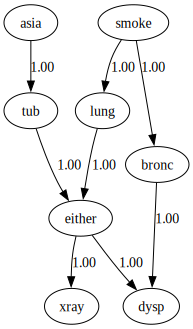

In [131]:
bn.plot_graphviz(model_asia)

In [13]:
train_d, val_d, test_d = np.split(df_asia.sample(frac=1, random_state = 1010), [int(num_samples*0.6), int(num_samples*0.8)])

KeyError: 0

## PC

## Train split

  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


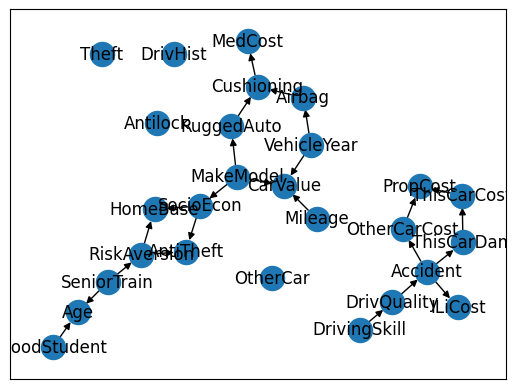

In [351]:
train_pc = run_pc(train_d, True)

In [352]:
print("SHD = ", SHD(nx.adjacency_matrix(train_pc, nodes_orig).toarray(), model_asia['adjmat'].to_numpy().astype(int)))

ValueError: operands could not be broadcast together with shapes (27,27) (8,8) 

## Validation Split

  0%|          | 0/5 [00:00<?, ?it/s]

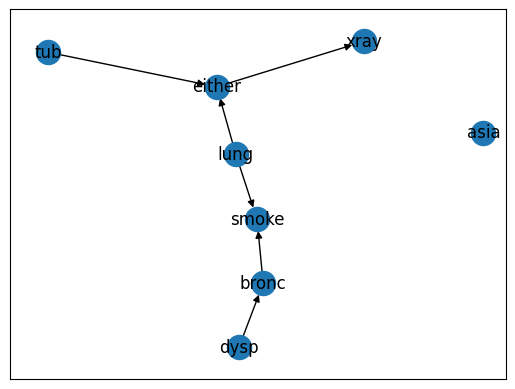

In [145]:
val_pc = run_pc(val_d, True)

In [147]:
print("SHD = ", SHD(nx.adjacency_matrix(val_pc, nodes_orig).toarray(), model_asia['adjmat'].to_numpy().astype(int)))

SHD =  8


## Test split

  0%|          | 0/5 [00:00<?, ?it/s]

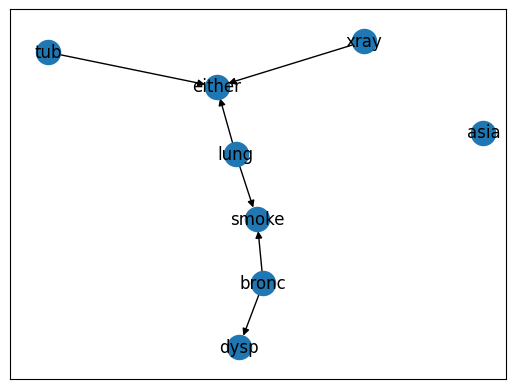

In [149]:
test_pc = run_pc(test_d, True)

In [150]:
print("SHD = ", SHD(nx.adjacency_matrix(test_pc, nodes_orig).toarray(), model_asia['adjmat'].to_numpy().astype(int)))

SHD =  8


## LINGAM

## Train

In [240]:
model = lingam.DirectLiNGAM(random_state=1010)
model.fit(train_d)

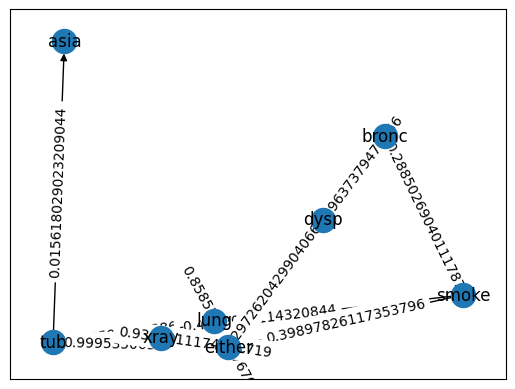

In [239]:
g = nx.from_pandas_adjacency(pd.DataFrame(model.adjacency_matrix_, columns=nodes_orig, index=nodes_orig), create_using=nx.DiGraph())
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos, with_labels=True)
nx.draw_networkx_edge_labels(g,pos, nx.get_edge_attributes(g, 'weight'))
plt.show()

In [238]:
print("Correlation against train dataset = ", correlation_score(DAG(g),train_d, test="chi_square", significance_level=0.05))
print("Correlation against full dataset = ", correlation_score(DAG(g),df_asia, test="chi_square", significance_level=0.05))

Correlation against train dataset =  0.23529411764705882
Correlation against full dataset =  0.125


## Val

In [244]:
model = lingam.DirectLiNGAM(random_state=1010)
model.fit(val_d)

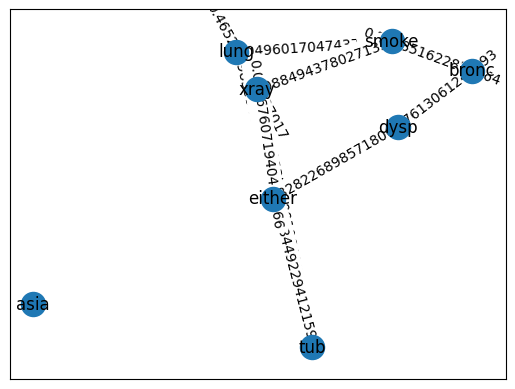

In [245]:
g = nx.from_pandas_adjacency(pd.DataFrame(model.adjacency_matrix_, columns=nodes_orig, index=nodes_orig), create_using=nx.DiGraph())
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos, with_labels=True)
nx.draw_networkx_edge_labels(g,pos, nx.get_edge_attributes(g, 'weight'))
plt.show()

In [246]:
print("Correlation against val dataset = ", correlation_score(DAG(g),val_d, test="chi_square", significance_level=0.05))
print("Correlation against full dataset = ", correlation_score(DAG(g),df_asia, test="chi_square", significance_level=0.05))

Correlation against val dataset =  0.7368421052631579
Correlation against full dataset =  0.5714285714285714


## Test

In [250]:
model = lingam.DirectLiNGAM(random_state=1010)
model.fit(test_d)

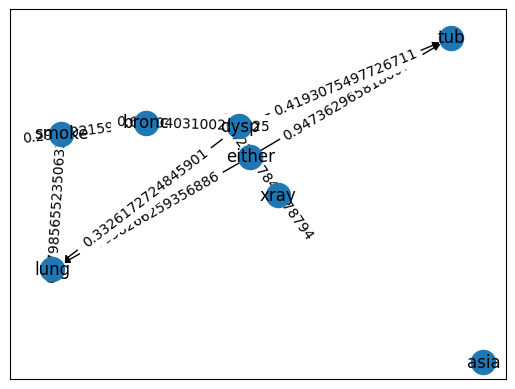

In [251]:
g = nx.from_pandas_adjacency(pd.DataFrame(model.adjacency_matrix_, columns=nodes_orig, index=nodes_orig), create_using=nx.DiGraph())
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos, with_labels=True)
nx.draw_networkx_edge_labels(g,pos, nx.get_edge_attributes(g, 'weight'))
plt.show()

In [252]:
print("Correlation against test dataset = ", correlation_score(DAG(g),test_d, test="chi_square", significance_level=0.05))
print("Correlation against full dataset = ", correlation_score(DAG(g),df_asia, test="chi_square", significance_level=0.05))

Correlation against test dataset =  0.7272727272727273
Correlation against full dataset =  0.4444444444444444


## Cancer

In [268]:
file_name = "cancer"
model_cancer = bn.import_DAG("BIFS/" + file_name + ".bif")
df_cancer = bn.sampling(model_cancer, n=num_samples)
nodes_orig = df_cancer.columns
df_cancer.head()

[bnlearn] >Import <BIFS/cancer.bif>
[bnlearn] >Loading bif file <BIFS/cancer.bif>
[bnlearn] >Check whether CPDs sum up to one.


,Pollution,Cancer,Smoker,Xray,Dyspnoea
0,0,1,1,1,0
1,0,1,0,1,0
2,1,1,1,0,1
3,0,1,1,1,1
4,0,1,0,1,1


[setgraphviz] >INFO> System found: osx
[setgraphviz] >INFO> The OS is not supported to automatically set Graphviz in the system env.
[setgraphviz] >INFO> Graphviz path found in environment.


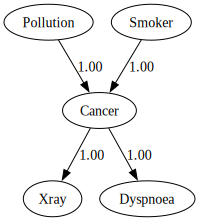

In [269]:
bn.plot_graphviz(model_cancer)

In [270]:
train_d, val_d, test_d = np.split(df_cancer.sample(frac=1, random_state = 1010), [int(num_samples*0.6), int(num_samples*0.8)])

## PC

## Train split

  0%|          | 0/5 [00:00<?, ?it/s]

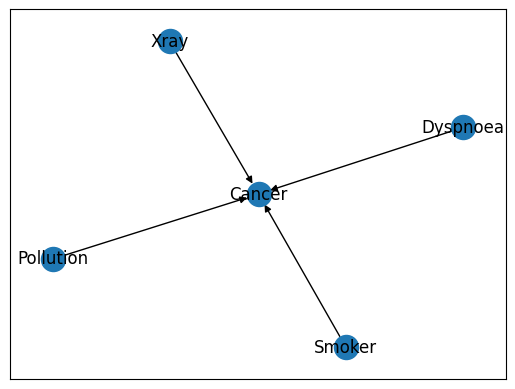

In [271]:
train_pc = run_pc(train_d, True)

In [272]:
print("SHD = ", SHD(nx.adjacency_matrix(train_pc, nodes_orig).toarray(), model_cancer['adjmat'].to_numpy().astype(int)))

SHD =  4


## Validation Split

  0%|          | 0/5 [00:00<?, ?it/s]

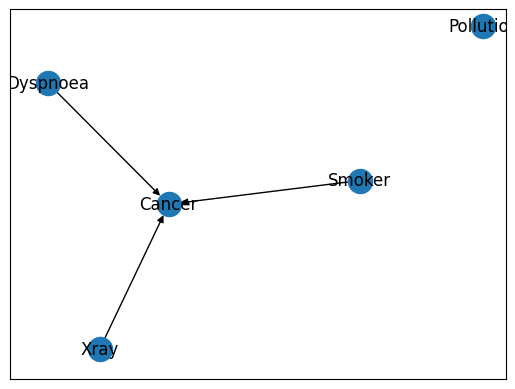

In [273]:
val_pc = run_pc(val_d, True)

In [274]:
print("SHD = ", SHD(nx.adjacency_matrix(val_pc, nodes_orig).toarray(), model_cancer['adjmat'].to_numpy().astype(int)))

SHD =  5


## Test split

  0%|          | 0/5 [00:00<?, ?it/s]

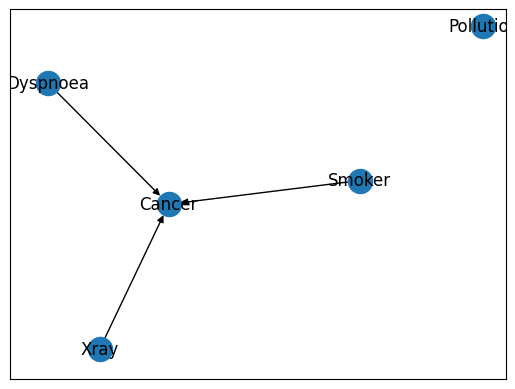

In [275]:
test_pc = run_pc(test_d, True)

In [276]:
print("SHD = ", SHD(nx.adjacency_matrix(test_pc, nodes_orig).toarray(), model_cancer['adjmat'].to_numpy().astype(int)))

SHD =  5


## LINGAM

## Train

In [277]:
model = lingam.DirectLiNGAM(random_state=1010)
model.fit(train_d)

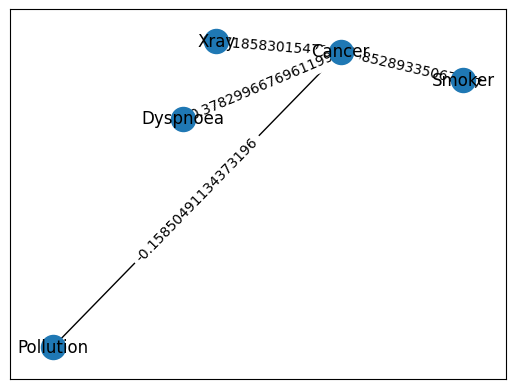

In [278]:
g = nx.from_pandas_adjacency(pd.DataFrame(model.adjacency_matrix_, columns=nodes_orig, index=nodes_orig), create_using=nx.DiGraph())
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos, with_labels=True)
nx.draw_networkx_edge_labels(g,pos, nx.get_edge_attributes(g, 'weight'))
plt.show()

In [280]:
print("Correlation against train dataset = ", correlation_score(DAG(g),train_d, test="chi_square", significance_level=0.05))
print("Correlation against full dataset = ", correlation_score(DAG(g),df_cancer, test="chi_square", significance_level=0.05))

Correlation against train dataset =  0.9090909090909091
Correlation against full dataset =  0.9090909090909091


## Val

In [281]:
model = lingam.DirectLiNGAM(random_state=1010)
model.fit(val_d)

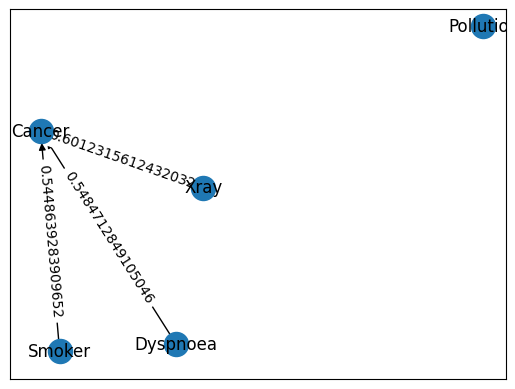

In [282]:
g = nx.from_pandas_adjacency(pd.DataFrame(model.adjacency_matrix_, columns=nodes_orig, index=nodes_orig), create_using=nx.DiGraph())
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos, with_labels=True)
nx.draw_networkx_edge_labels(g,pos, nx.get_edge_attributes(g, 'weight'))
plt.show()

In [283]:
print("Correlation against val dataset = ", correlation_score(DAG(g),val_d, test="chi_square", significance_level=0.05))
print("Correlation against full dataset = ", correlation_score(DAG(g),df_cancer, test="chi_square", significance_level=0.05))

Correlation against val dataset =  1.0
Correlation against full dataset =  0.8333333333333334


## Test

In [284]:
model = lingam.DirectLiNGAM(random_state=1010)
model.fit(test_d)

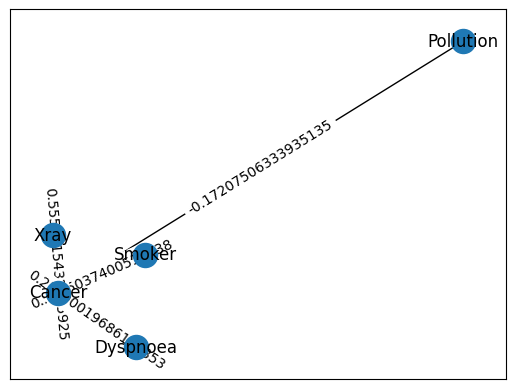

In [285]:
g = nx.from_pandas_adjacency(pd.DataFrame(model.adjacency_matrix_, columns=nodes_orig, index=nodes_orig), create_using=nx.DiGraph())
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos, with_labels=True)
nx.draw_networkx_edge_labels(g,pos, nx.get_edge_attributes(g, 'weight'))
plt.show()

In [286]:
print("Correlation against test dataset = ", correlation_score(DAG(g),test_d, test="chi_square", significance_level=0.05))
print("Correlation against full dataset = ", correlation_score(DAG(g),df_cancer, test="chi_square", significance_level=0.05))

Correlation against test dataset =  0.9090909090909091
Correlation against full dataset =  0.9090909090909091


# Medium networks

## Child

In [295]:
model_child = bn.import_DAG("BIFS/child.bif")
df_child = bn.sampling(model_child, n=num_samples)
nodes_orig = df_child.columns

[bnlearn] >Import <BIFS/child.bif>
[bnlearn] >Loading bif file <BIFS/child.bif>


[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 3.3306690738754696e-16. Adjusting values.


[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >CPD [Age] does not add up to 1 but is: [[1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[bnlearn] >CPD [ChestXray] does not add up to 1 but is: [[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
[bnlearn] >CPD [HypoxiaInO2] does not add up to 1 but is: [[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
[bnlearn] >CPD [LowerBodyO2] does not add up to 1 but is: [[1. 1. 1.]
 [1. 1. 1.]]
[bnlearn] >CPD [RUQO2] does not add up to 1 but is: [1. 1. 1.]
[bnlearn] >CPD [XrayReport] does not add up to 1 but is: [1. 1. 1. 1. 1.]


[setgraphviz] >INFO> System found: osx
[setgraphviz] >INFO> The OS is not supported to automatically set Graphviz in the system env.
[setgraphviz] >INFO> Graphviz path found in environment.


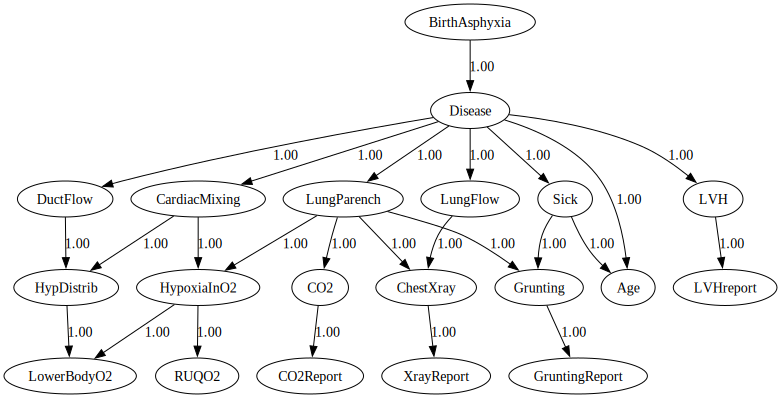

In [296]:
bn.plot_graphviz(model_child)

In [297]:
train_d, val_d, test_d = np.split(df_child.sample(frac=1, random_state = 1010), [int(num_samples*0.6), int(num_samples*0.8)])

## PC

## Train split

  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


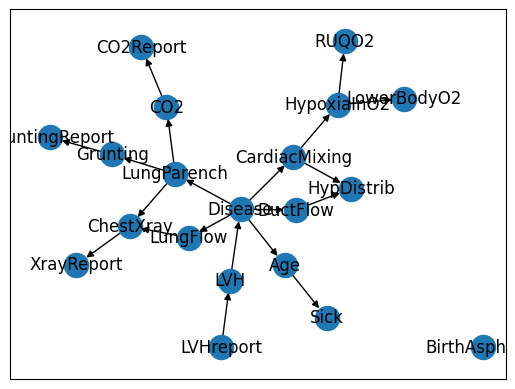

In [298]:
train_pc = run_pc(train_d, True)

In [299]:
print("SHD = ", SHD(nx.adjacency_matrix(train_pc, nodes_orig).toarray(), model_child['adjmat'].to_numpy().astype(int)))

SHD =  11


## Validation Split

  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


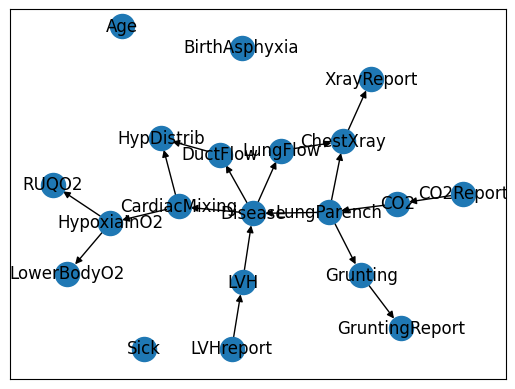

In [300]:
val_pc = run_pc(val_d, True)

In [301]:
print("SHD = ", SHD(nx.adjacency_matrix(val_pc, nodes_orig).toarray(), model_child['adjmat'].to_numpy().astype(int)))

SHD =  17


## Test split

  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


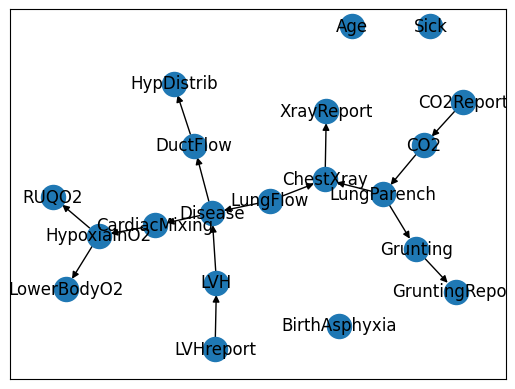

In [302]:
test_pc = run_pc(test_d, True)

In [303]:
print("SHD = ", SHD(nx.adjacency_matrix(test_pc, nodes_orig).toarray(), model_child['adjmat'].to_numpy().astype(int)))

SHD =  19


## LINGAM

## Train

In [304]:
model = lingam.DirectLiNGAM(random_state=1010)
model.fit(train_d)

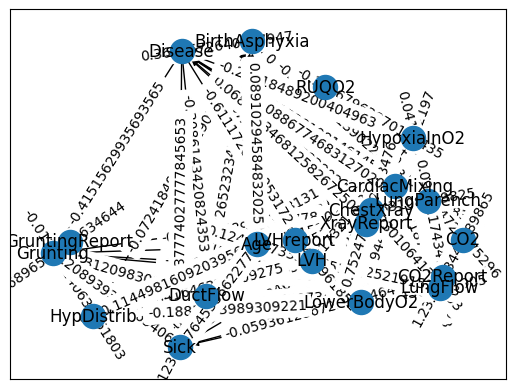

In [305]:
g = nx.from_pandas_adjacency(pd.DataFrame(model.adjacency_matrix_, columns=nodes_orig, index=nodes_orig), create_using=nx.DiGraph())
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos, with_labels=True)
nx.draw_networkx_edge_labels(g,pos, nx.get_edge_attributes(g, 'weight'))
plt.show()

In [306]:
print("Correlation against train dataset = ", correlation_score(DAG(g),train_d, test="chi_square", significance_level=0.05))
print("Correlation against full dataset = ", correlation_score(DAG(g),df_child, test="chi_square", significance_level=0.05))

Correlation against train dataset =  0.24
Correlation against full dataset =  0.2222222222222222


## Val

In [307]:
model = lingam.DirectLiNGAM(random_state=1010)
model.fit(val_d)

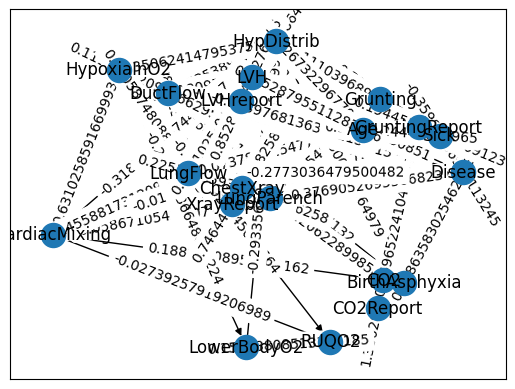

In [308]:
g = nx.from_pandas_adjacency(pd.DataFrame(model.adjacency_matrix_, columns=nodes_orig, index=nodes_orig), create_using=nx.DiGraph())
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos, with_labels=True)
nx.draw_networkx_edge_labels(g,pos, nx.get_edge_attributes(g, 'weight'))
plt.show()

In [309]:
print("Correlation against val dataset = ", correlation_score(DAG(g),val_d, test="chi_square", significance_level=0.05))
print("Correlation against full dataset = ", correlation_score(DAG(g),df_child, test="chi_square", significance_level=0.05))

Correlation against val dataset =  0.3838383838383838
Correlation against full dataset =  0.2682926829268293


## Test

In [310]:
model = lingam.DirectLiNGAM(random_state=1010)
model.fit(test_d)

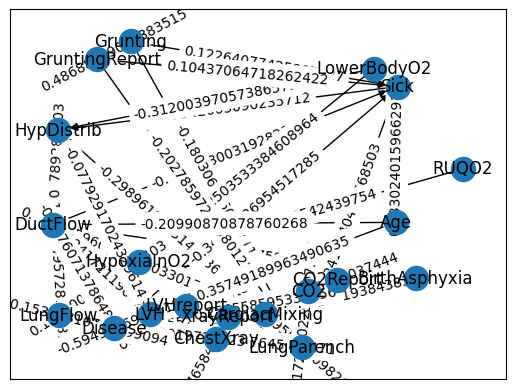

In [311]:
g = nx.from_pandas_adjacency(pd.DataFrame(model.adjacency_matrix_, columns=nodes_orig, index=nodes_orig), create_using=nx.DiGraph())
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos, with_labels=True)
nx.draw_networkx_edge_labels(g,pos, nx.get_edge_attributes(g, 'weight'))
plt.show()

In [312]:
print("Correlation against test dataset = ", correlation_score(DAG(g),test_d, test="chi_square", significance_level=0.05))
print("Correlation against full dataset = ", correlation_score(DAG(g),df_child, test="chi_square", significance_level=0.05))

Correlation against test dataset =  0.6071428571428571
Correlation against full dataset =  0.47761194029850745


## Insurance

In [314]:
model_insurance = bn.import_DAG("BIFS/insurance.bif")
df_insurance = bn.sampling(model_insurance, n=10000)
nodes_orig = df_insurance.columns

[bnlearn] >Import <BIFS/insurance.bif>
[bnlearn] >Loading bif file <BIFS/insurance.bif>


[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
[setgraphviz] >WARNING> Probability value

[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >CPD [Accident] does not add up to 1 but is: [[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]
[bnlearn] >CPD [CarValue] does not add up to 1 but is: [[[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]]]
[bnlearn] >CPD [DrivHist] does not add up to 1 but is: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[bnlearn] >CPD [DrivingSkill] does not add up to 1 but is: [[1. 1.]
 [1. 1.]
 [1. 1.]]
[bnlearn] >CPD [HomeBase] does not add up to 1 but is: [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
[bnlearn] >CPD [MedCost] does not add up to 1 but is: [[[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]]
[bnlearn]

[setgraphviz] >INFO> System found: osx
[setgraphviz] >INFO> The OS is not supported to automatically set Graphviz in the system env.
[setgraphviz] >INFO> Graphviz path found in environment.


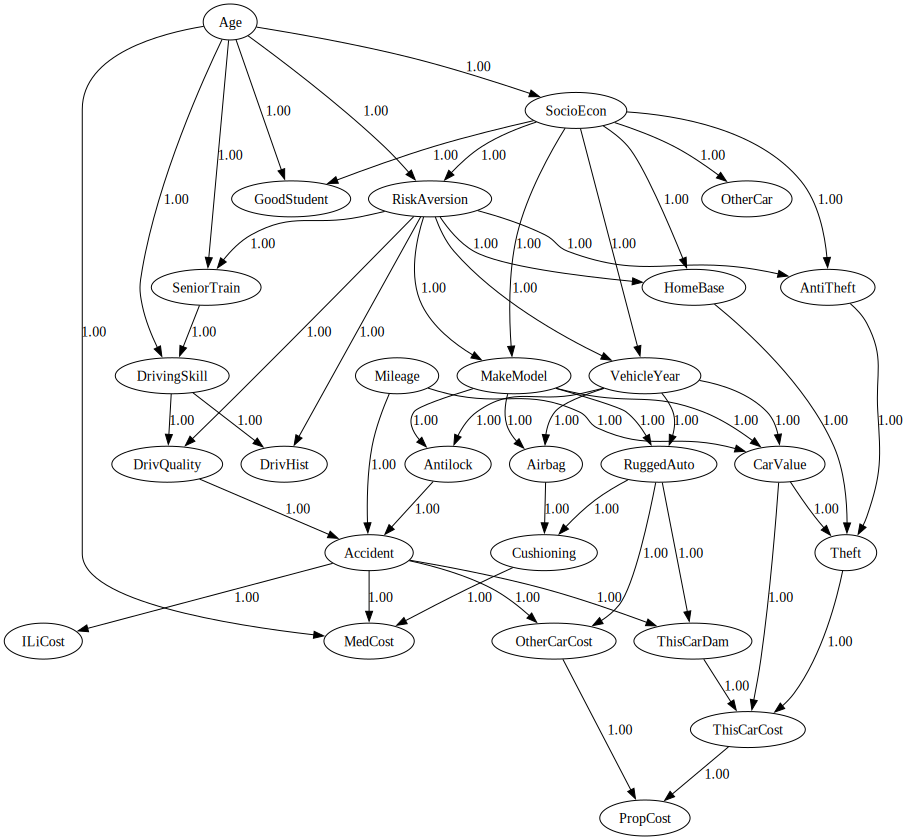

In [315]:
bn.plot_graphviz(model_insurance)

In [316]:
train_d, val_d, test_d = np.split(df_insurance.sample(frac=1, random_state = 1010), [int(num_samples*0.6), int(num_samples*0.8)])

## PC

## Train split

  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


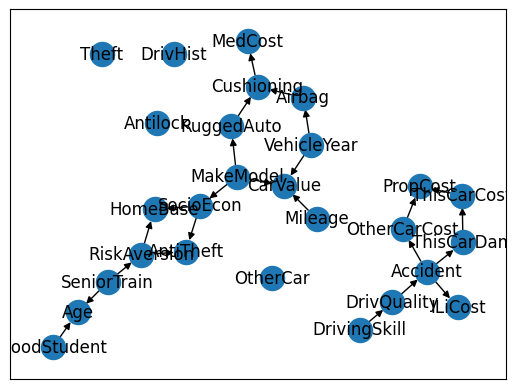

In [318]:
train_pc = run_pc(train_d, True)

In [319]:
print("SHD = ", SHD(nx.adjacency_matrix(train_pc, nodes_orig).toarray(), model_insurance['adjmat'].to_numpy().astype(int)))

SHD =  36


## Validation Split

  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


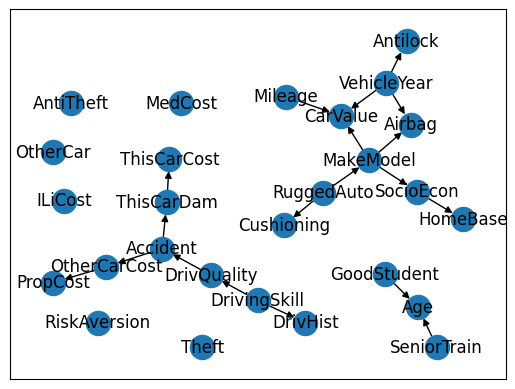

In [320]:
val_pc = run_pc(val_d, True)

In [322]:
print("SHD = ", SHD(nx.adjacency_matrix(val_pc, nodes_orig).toarray(), model_insurance['adjmat'].to_numpy().astype(int)))

SHD =  41


## Test split

  0%|          | 0/5 [00:00<?, ?it/s]

[setgraphviz] >INFO> Reached maximum number of allowed conditional variables. Exiting


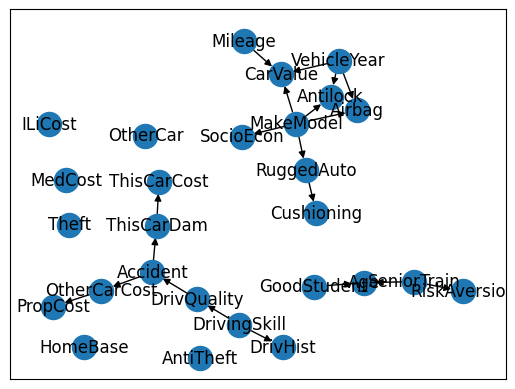

In [323]:
test_pc = run_pc(test_d, True)

In [326]:
print("SHD = ", SHD(nx.adjacency_matrix(test_pc, nodes_orig).toarray(), model_insurance['adjmat'].to_numpy().astype(int)))

SHD =  40


## LINGAM

## Train

In [327]:
model = lingam.DirectLiNGAM(random_state=1010)
model.fit(train_d)

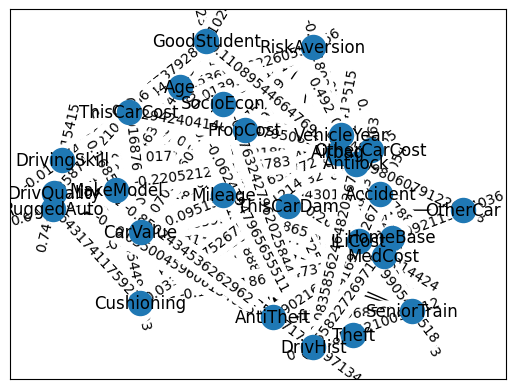

In [328]:
g = nx.from_pandas_adjacency(pd.DataFrame(model.adjacency_matrix_, columns=nodes_orig, index=nodes_orig), create_using=nx.DiGraph())
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos, with_labels=True)
nx.draw_networkx_edge_labels(g,pos, nx.get_edge_attributes(g, 'weight'))
plt.show()

In [329]:
print("Correlation against train dataset = ", correlation_score(DAG(g),train_d, test="chi_square", significance_level=0.05))
print("Correlation against full dataset = ", correlation_score(DAG(g),df_insurance, test="chi_square", significance_level=0.05))

Correlation against train dataset =  0.016260162601626018
Correlation against full dataset =  0.017543859649122806


## Val

In [330]:
model = lingam.DirectLiNGAM(random_state=1010)
model.fit(val_d)

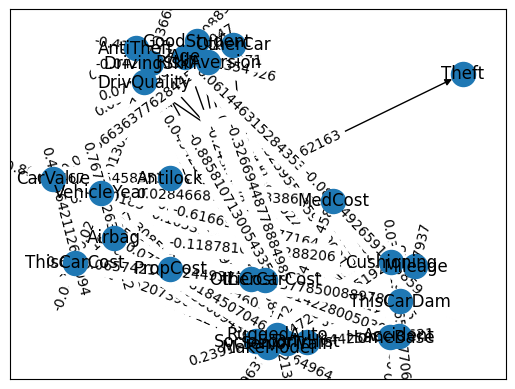

In [331]:
g = nx.from_pandas_adjacency(pd.DataFrame(model.adjacency_matrix_, columns=nodes_orig, index=nodes_orig), create_using=nx.DiGraph())
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos, with_labels=True)
nx.draw_networkx_edge_labels(g,pos, nx.get_edge_attributes(g, 'weight'))
plt.show()

In [332]:
print("Correlation against val dataset = ", correlation_score(DAG(g),val_d, test="chi_square", significance_level=0.05))
print("Correlation against full dataset = ", correlation_score(DAG(g),df_insurance, test="chi_square", significance_level=0.05))

Correlation against val dataset =  0.42748091603053434
Correlation against full dataset =  0.3826086956521739


## Test

In [333]:
model = lingam.DirectLiNGAM(random_state=1010)
model.fit(test_d)

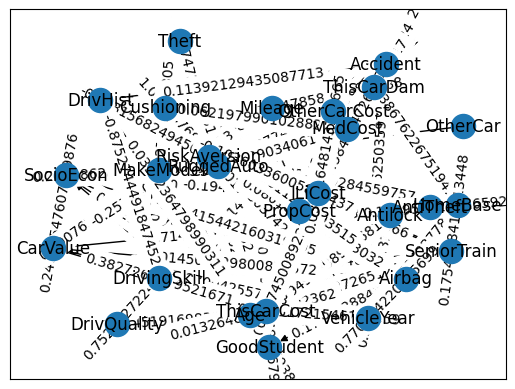

In [334]:
g = nx.from_pandas_adjacency(pd.DataFrame(model.adjacency_matrix_, columns=nodes_orig, index=nodes_orig), create_using=nx.DiGraph())
pos = nx.spring_layout(g)
nx.draw_networkx(g, pos, with_labels=True)
nx.draw_networkx_edge_labels(g,pos, nx.get_edge_attributes(g, 'weight'))
plt.show()

In [335]:
print("Correlation against test dataset = ", correlation_score(DAG(g),test_d, test="chi_square", significance_level=0.05))
print("Correlation against full dataset = ", correlation_score(DAG(g),df_insurance, test="chi_square", significance_level=0.05))

Correlation against test dataset =  0.4462809917355372
Correlation against full dataset =  0.3864734299516908


# Very Large Networks

## Diabetes

In [438]:
model_diabetes = bn.import_DAG("BIFS/diabetes.bif")
df_diabetes = bn.sampling(model_diabetes, n=1000)
df_diabetes.head()

[bnlearn] >Import <BIFS/diabetes.bif>
[bnlearn] >Loading bif file <BIFS/diabetes.bif>


[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 3.3306690738754696e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability value

[bnlearn] >Check whether CPDs sum up to one.
[bnlearn] >CPD [activ_ins_0] does not add up to 1 but is: [[1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.00000001 1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]]
[bnlearn] >CPD [activ_ins_1] does not add up to 1 but is: [[1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.

[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 3.3306690738754696e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 1.1102230246251565e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: 2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability values don't exactly sum to 1. Differ by: -2.220446049250313e-16. Adjusting values.
[setgraphviz] >WARNING> Probability value

,meal_0,cho_0,cho_init,ins_abs_0,activ_ins_0,ins_sens,gut_abs_0,bg_0,renal_cl_0,ins_indep_util_0,...,ins_indep_23,ins_dep_23,endo_bal_23,cho_bal_23,basal_bal_23,tot_bal_23,met_irr_23,meal_24,cho_24,bg_24
0,20,20,15,5,3,0,5,7,2,1,...,4,2,2,14,2,2,3,20,18,4
1,20,20,15,5,3,0,5,6,2,1,...,1,5,8,0,6,6,3,20,6,0
2,8,7,15,6,7,3,2,8,2,1,...,1,4,7,12,7,7,3,20,16,0
3,20,19,15,3,4,3,5,5,2,0,...,1,5,8,15,9,9,3,20,20,3
4,20,19,15,7,8,3,5,5,2,0,...,1,2,5,15,7,6,2,3,5,0


[setgraphviz] >INFO> System found: osx
[setgraphviz] >INFO> The OS is not supported to automatically set Graphviz in the system env.
[setgraphviz] >INFO> Graphviz path found in environment.


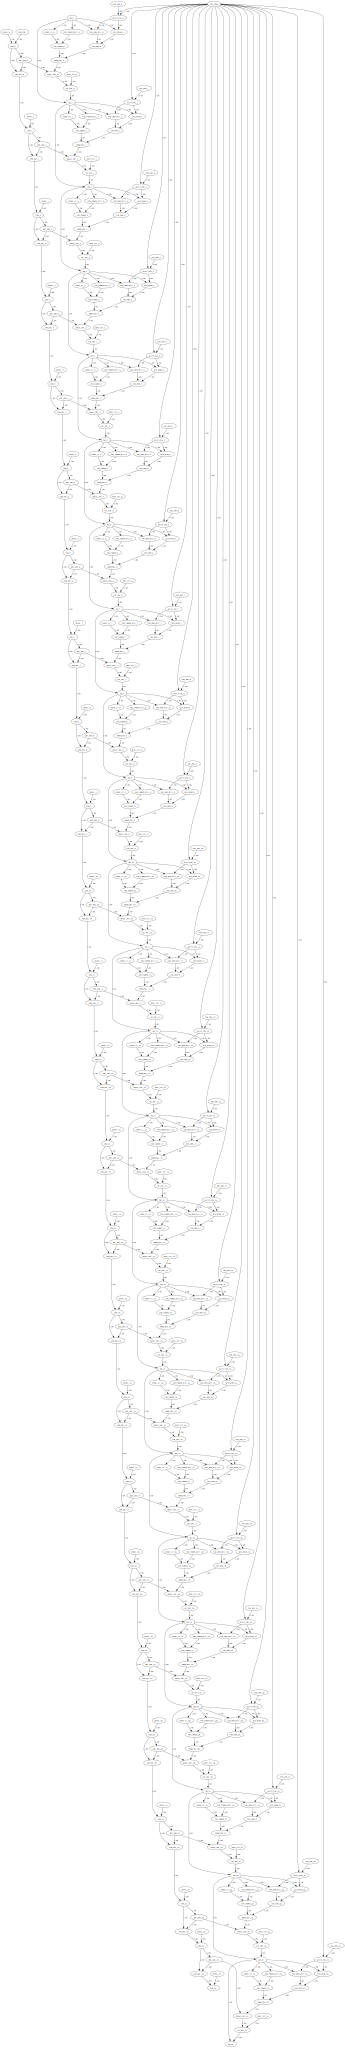

In [74]:
bn.plot_graphviz(model_diabetes)

## PC

In [77]:
pc_G, labels = run_pc(df_diabetes)

  0%|          | 0/413 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
get_comparison_metrics(model_diabetes['adjmat'].to_numpy().astype(int), (pc_G.graph.T).astype(int))

## FCI

In [439]:
fci_G, labels = run_fci(df_diabetes)

  0%|          | 0/413 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
get_comparison_metrics(model_cancer['adjmat'].to_numpy().astype(int), (fci_G.graph.T).astype(int))

## GES

In [440]:
ges_G, labels = run_ges(df_diabetes)

KeyboardInterrupt: 

In [ ]:
get_comparison_metrics(model_diabetes['adjmat'].to_numpy().astype(int), (ges_G.graph.T).astype(int))